In [1]:
import numpy as np
import matplotlib.pyplot as plt

from helper_functions_tsp import read_file_name, validate_distance_array
from helper_functions_tsp import find_problem_size, cost_fn_fact
from quantum_functions import define_parameters, create_initial_rotations
from quantum_functions import bind_weights, vqc_circuit, my_gradient, cost_func_evaluate

In [2]:
LOCATIONS = 5                 #number of locations to be visited
VERBOSE = False               #controls how much is printed
TOLERANCE = 1e-1              #Tolerance
SHOTS = 1024                  #shots used for each call of the quantum circuit
EPSILON = np.pi/2             #constant for parameter shift
SHOW_CIRCUITS = True          #Show the quantum circuits
MODE = 2                      # MODE = 1 rxgate, rygate, cnot gates
                              # MODE = 2 rxgate, XX gates
#RELEVANT_VALUES = 50         #controls how many of the items to average over as a percentage
                              #eg 100 = all 
                              #30 = top 30%
ETA = 0.005                   #eta - learning rate for parameter shift
UPDATES = 50                  #updates, or iterations
PRINT_FREQUENCY = 10          #how often results are printed out
GRAY = True                   #Use Gray codes
#SPSA = False                 #SPSA stochastic gradient descent used

From the number of locations visited find the qubits and longest binary string.

In [3]:
bin_len, qubits = find_problem_size(LOCATIONS)
print(f'There are {qubits} qubits needed.  The longest binary string is {bin_len}')

There are 5 qubits needed.  The longest binary string is 2


Data sources are held locally to avoid downstream dependencies.

In [4]:
data_sources = {  4 : {'file' : 'data/four_d.txt', 'best' : 21},
                  5 : {'file' : 'data/five_d.txt', 'best' : 19},
                 11 : {'file' : 'data/dg11_d.txt', 'best' : 253},
                 15 : {'file' : 'data/p01_d.txt',  'best' : 291},
                 17 : {'file' : 'data/gr17_d.txt', 'best' : 2085},
                 26 : {'file' : 'data/fri26_d.txt', 'best' : 699},
                 42 : {'file' : 'data/dantzig42_d.txt', 'best' : 33_523},
                }

Read the data, and print out the filename and best distance held in the data.

In [5]:
filename = read_file_name(LOCATIONS, data_sources)
best_dist = data_sources[LOCATIONS]['best']
print(f'Data will be read from filename {filename}.  It is known that the shortest distance is {best_dist}.')

Data will be read from filename data/five_d.txt.  It is known that the shortest distance is 19.


Read and validate the distance array.  This checks the array is the correct shape, and is symmetric.

In [6]:
distance_array = np.genfromtxt(filename)
validate_distance_array(distance_array, LOCATIONS)

Define the VQC circuits with appropriate parameters, and draw the circuit.

In [7]:
params = define_parameters(qubits, MODE)



In [8]:
qc = vqc_circuit(qubits, params, MODE)

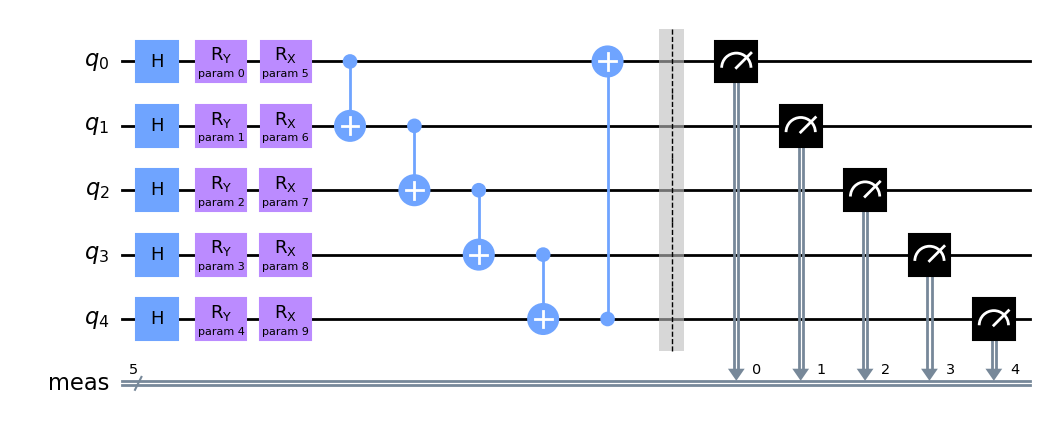

In [9]:
qc.draw("mpl", style="clifford")

Create random initial rotations, and bind these to the parameters in a new circuit `bc`.

In [10]:
init_rots = create_initial_rotations(qubits)
bc = bind_weights(params, init_rots, qc)
bc.measure_all()
if SHOW_CIRCUITS:
    bc.draw("mpl", style="clifford")

In [11]:
cost_fn = cost_fn_fact(LOCATIONS, distance_array, gray=GRAY, verbose=False)
cost_start, lowest_to_date, _ = cost_func_evaluate(cost_fn, bc, SHOTS)
print(f'For the starting circuit the average cost is {cost_start} and the lowest cost is {lowest_to_date}')

For the starting circuit the average cost is 22.94140625 and the lowest cost is 19.0


In [12]:
rots = init_rots
cost_list, lowest_list, index_list, gradient_list = [], [], [], []
for i in range(UPDATES):
    bc = bind_weights(params, rots, qc)
    cost, lowest, lowest_energy_bit_string = cost_func_evaluate(cost_fn, bc, SHOTS)
    if i == 0:
        lowest_string_to_date = lowest_energy_bit_string
        lowest_to_date = lowest
    if lowest < lowest_to_date:
        lowest = lowest_to_date
        lowest_string_to_date = lowest_energy_bit_string
    index_list.append(i)
    cost_list.append(cost)
    lowest_list.append(lowest)
    gradient = np.array(my_gradient(cost_fn, qc, params, rots, EPSILON, SHOTS))
    gradient_list.append(gradient)
    if i % PRINT_FREQUENCY == 0:
        print(f'For iteration {i} the average cost from the sample is {cost} and the lowest cost from the sample is {lowest}')
        print(f'The lowest cost to date is {lowest_to_date} corresponding to bit string {lowest_string_to_date}')
        if VERBOSE:
            print(f'The gradient is {gradient}')
    rots = rots - ETA * gradient

For iteration 0 the average cost from the sample is 22.935546875 and the lowest cost from the sample is 19.0
The lowest cost to date is 19.0 corresponding to bit string [0, 1, 0, 0, 1]
For iteration 10 the average cost from the sample is 22.88671875 and the lowest cost from the sample is 19.0
The lowest cost to date is 19.0 corresponding to bit string [0, 1, 0, 0, 1]
For iteration 20 the average cost from the sample is 22.89453125 and the lowest cost from the sample is 19.0
The lowest cost to date is 19.0 corresponding to bit string [0, 1, 0, 0, 1]
For iteration 30 the average cost from the sample is 22.919921875 and the lowest cost from the sample is 19.0
The lowest cost to date is 19.0 corresponding to bit string [0, 1, 0, 0, 1]
For iteration 40 the average cost from the sample is 23.056640625 and the lowest cost from the sample is 19.0
The lowest cost to date is 19.0 corresponding to bit string [0, 1, 0, 0, 1]


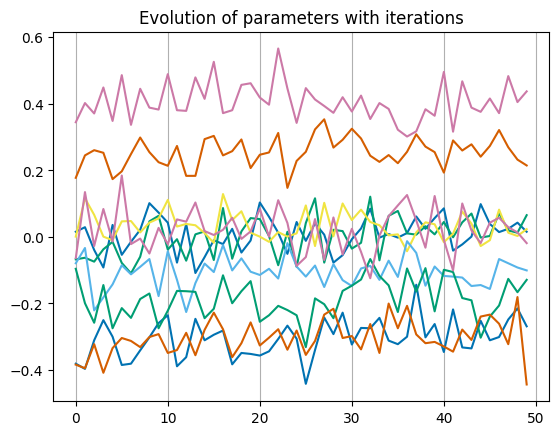

In [13]:
#plt.style.use('_mpl-gallery')
#plt.style.use('classic')
plt.style.use('seaborn-v0_8-colorblind')
plt.plot(index_list, gradient_list)
plt.grid(axis='x')
plt.title('Evolution of parameters with iterations')
plt.show()


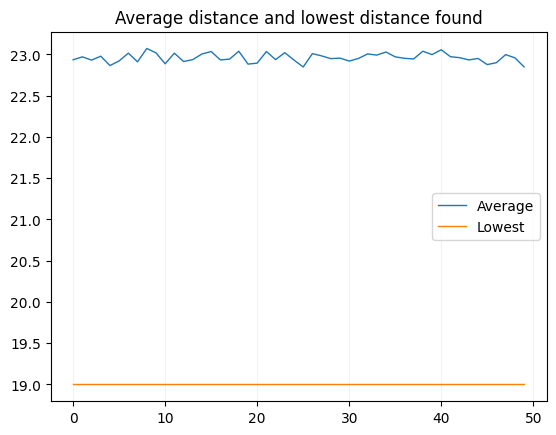

In [14]:
plt.style.use('default')
plt.plot(index_list, cost_list, linewidth=1.0, label='Average')
plt.step(index_list, lowest_list, linewidth=1.0, label='Lowest')
plt.grid(axis='x', color='0.95')
plt.title('Average distance and lowest distance found')
plt.legend()
plt.show()